# DA5401 A5: Visualizing Data Veracity Challenges in Multi-Label Classification

***Name:** Aaradhya Dashore* <br>
***Roll No:** ME22B089*

---

## Part A: Preprocessing and Initial Setup
### Part A.1 & A.2:
In this section, we begin by loading the **Yeast dataset** from the Mulan repository. Each instance represents a gene expression experiment with **86 features** (gene expression levels), and the target is a **multi-label matrix with 14 functional categories**.  

We will:
1. Load the dataset from the `.arff` file.  
2. Separate features (X) and labels (Y).  
3. Check dataset dimensions.  
4. Prepare the data for visualization in later steps.


In [17]:
%pip install liac-arff

import arff
import pandas as pd
import xml.etree.ElementTree as ET

# --- Step 1: parse XML to get label names ---
xml_path = "yeast.xml"
tree = ET.parse(xml_path)
root = tree.getroot()
label_names = [lbl.get("name") for lbl in root.findall(".//{http://mulan.sourceforge.net/labels}label")]

# --- Step 2: load ARFF into DataFrame ---
arff_path = "yeast.arff"
dataset = arff.load(open(arff_path, "r"))
df = pd.DataFrame(dataset['data'], columns=[a[0] for a in dataset['attributes']])

# --- Step 3: split into features (X) and labels (Y) ---
Y = df[label_names].values
X = df.drop(columns=label_names).values

feature_names = [c for c in df.columns if c not in label_names]

print("Feature matrix X shape:", X.shape)   # (2417, 103)
print("Label matrix Y shape:", Y.shape)     # (2417, 14)


Note: you may need to restart the kernel to use updated packages.
Feature matrix X shape: (2417, 103)
Label matrix Y shape: (2417, 14)


### Part A.3: Label Selection for Visualization

Since the dataset has **14 labels** and many possible multi-label combinations, directly coloring by all of them would clutter the visualization.  
To make the plots interpretable, we simplify the target variable:

1. Identify the **two most frequent single-label classes**.  
2. Identify the **most frequent multi-label combination**.  
3. Group all remaining samples into a single `"Other"` category.  

This approach ensures we only have a few distinct colors in the plots while still capturing the most important label patterns in the dataset.


In [18]:
# === Part A.3: Reliable 4-category simplification (paste/replace in your notebook) ===
import numpy as np
import pandas as pd

# Build Y_df if not present
if 'Y_df' not in globals():
    if 'Y' in globals() and 'label_names' in globals():
        Y_df = pd.DataFrame(np.asarray(Y, dtype=int), columns=label_names)
    elif 'df' in globals() and 'label_names' in globals():
        Y_df = pd.DataFrame(df[label_names].values.astype(int), columns=label_names)
    else:
        raise RuntimeError("Missing Y and label_names. Ensure Y and label_names (or Y_df) exist.")

Y_df = Y_df.astype(int)   # ensure ints

n_samples = Y_df.shape[0]

# 1) single-label rows and counts
single_mask = (Y_df.sum(axis=1) == 1)
single_rows = Y_df.loc[single_mask]
single_label_counts = single_rows.sum(axis=0).sort_values(ascending=False)

# pick top 2 single-label classes but only those with >0 counts
top2_single = list(single_label_counts[single_label_counts > 0].index[:2])

# fallback: if <2 found, use overall label frequency (non-zero) to fill
if len(top2_single) < 2:
    overall_counts = Y_df.sum(axis=0).sort_values(ascending=False)
    for nm in overall_counts.index:
        if nm not in top2_single and overall_counts.loc[nm] > 0:
            top2_single.append(nm)
        if len(top2_single) == 2:
            break

# final fallback if still <2 (very unlikely): pick highest overall (even if zero)
if len(top2_single) < 2:
    overall_counts = Y_df.sum(axis=0).sort_values(ascending=False)
    for nm in overall_counts.index:
        if nm not in top2_single:
            top2_single.append(nm)
        if len(top2_single) == 2:
            break

# 2) most frequent multi-label tuple (from rows with >1 ones)
multi_mask = (Y_df.sum(axis=1) > 1)
top_multi_tuple = None
top_multi_count = 0
if multi_mask.any():
    multi_rows = Y_df.loc[multi_mask]
    tuple_series = multi_rows.apply(lambda r: tuple(r.values.tolist()), axis=1)
    combo_counts = tuple_series.value_counts()
    top_multi_tuple = combo_counts.index[0]
    top_multi_count = int(combo_counts.iloc[0])

# 3) assign each row to one of four categories
def assign_category(row):
    s = int(row.sum())
    if s == 1:
        # single-label -> check if it is one of top2 singles
        label = row.index[row == 1][0]
        if label == top2_single[0]:
            return top2_single[0]
        if label == top2_single[1]:
            return top2_single[1]
        return "Other"
    elif s > 1 and top_multi_tuple is not None and tuple(row.values.tolist()) == top_multi_tuple:
        return "Top-Multi"
    else:
        return "Other"

simplified_label = Y_df.apply(assign_category, axis=1)   # Series of strings

# ordered categories and numeric code (0..3) for plotting
categories = [top2_single[0], top2_single[1], "Top-Multi", "Other"]
cat_to_code = {c: i for i, c in enumerate(categories)}
simplified_code = simplified_label.map(cat_to_code).fillna(cat_to_code["Other"]).astype(int)

# 4) attach to dataframe (optional but convenient)
try:
    df['simplified_label'] = simplified_label.values
    df['simplified_code'] = simplified_code.values
except Exception:
    # if df not present or write fails, it's okay - user still has simplified_label & simplified_code
    pass

# 5) verification prints (quick check)
print("Selected top-2 single-label classes:", top2_single)
print("\nSingle-label counts (rows with exactly one active label):")
print(single_label_counts.to_string())

print("\nTop multi-label tuple (from rows with >1 labels) and its count:")
if top_multi_tuple is not None:
    print(top_multi_tuple, "->", top_multi_count)
else:
    print("No multi-label rows present.")

print("\nFinal simplified distribution (ordered):")
dist = simplified_label.value_counts().reindex(categories, fill_value=0)
print(dist.to_string())

# sanity check: counts sum to n_samples
assert dist.sum() == n_samples, f"Count mismatch: {dist.sum()} vs {n_samples}"

# show a few example indices for verification
print("\nExample indices for each category (up to 5):")
for c in categories:
    idxs = simplified_label[simplified_label == c].index[:5].tolist()
    print(f"  {c}: {idxs}")

# End: variables available for later steps:
#   simplified_label (pd.Series of str), simplified_code (pd.Series of int), categories (list)


Selected top-2 single-label classes: ['Class1', 'Class12']

Single-label counts (rows with exactly one active label):
Class1     32
Class2      0
Class3      0
Class6      0
Class4      0
Class10     0
Class11     0
Class5      0
Class7      0
Class8      0
Class9      0
Class12     0
Class13     0
Class14     0

Top multi-label tuple (from rows with >1 labels) and its count:
(0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0) -> 237

Final simplified distribution (ordered):
Class1         32
Class12         0
Top-Multi     237
Other        2148

Example indices for each category (up to 5):
  Class1: [171, 524, 552, 674, 692]
  Class12: []
  Top-Multi: [9, 19, 20, 35, 53]
  Other: [0, 1, 2, 3, 4]


### Part A.4: Feature Scaling

Both **t-SNE** and **Isomap** are distance-based manifold learning algorithms.  
If the features are not scaled, attributes with larger numeric ranges can dominate  
the distance computation and distort the embedding.

Hence, we apply **Standardization**, transforming each feature to have:
- Mean = 0  
- Standard deviation = 1  

This ensures all 103 gene expression features contribute equally to the manifold structure.


In [19]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the feature matrix
X_scaled = scaler.fit_transform(X)

# Check results
print("Original shape:", X.shape)
print("Scaled shape:", X_scaled.shape)
print("Mean (approx):", np.mean(X_scaled, axis=0)[:5])
print("Std (approx):", np.std(X_scaled, axis=0)[:5])


Original shape: (2417, 103)
Scaled shape: (2417, 103)
Mean (approx): [ 1.98434566e-17 -8.81931406e-18 -7.34942838e-18  1.02891997e-17
 -1.76386281e-17]
Std (approx): [1. 1. 1. 1. 1.]


---

## Part B: t-SNE and Veracity Inspection:
### Part B.1 – t-SNE Implementation and Perplexity Experiments

We now apply **t-Distributed Stochastic Neighbor Embedding (t-SNE)** to the scaled feature matrix to obtain a 2-D embedding for visual inspection of label veracity issues (noisy labels, outliers, and hard-to-learn samples).

Notes:
- t-SNE is sensitive to the **perplexity** hyperparameter, which roughly controls
  the number of nearest neighbors considered when preserving local structure.
- We’ll try multiple values (5, 30, 50) to study how local vs global structure
  changes.
- To improve speed and stability, we first reduce the 103-D data to 50 D using PCA.
- Each point will be colored by the simplified 4-category label created in Part A.3.


Running t-SNE (perplexity=5) ...
[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 2417 samples in 0.000s...
[t-SNE] Computed neighbors for 2417 samples in 0.050s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2417
[t-SNE] Computed conditional probabilities for sample 2000 / 2417
[t-SNE] Computed conditional probabilities for sample 2417 / 2417
[t-SNE] Mean sigma: 2.180468
[t-SNE] KL divergence after 250 iterations with early exaggeration: 98.586273
[t-SNE] KL divergence after 1000 iterations: 2.023430
Running t-SNE (perplexity=30) ...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2417 samples in 0.003s...
[t-SNE] Computed neighbors for 2417 samples in 0.074s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2417
[t-SNE] Computed conditional probabilities for sample 2000 / 2417
[t-SNE] Computed conditional probabilities for sample 2417 / 2417
[t-SNE] Mean sigma: 3.148491
[t-SNE] KL divergence after 250 iterations with early exaggeratio

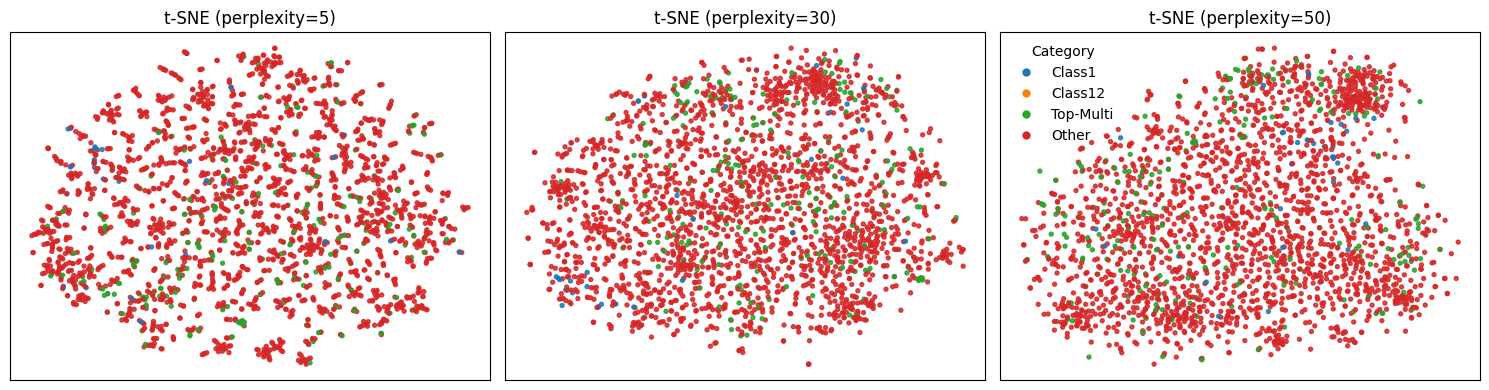

In [20]:
# === Part B.1 (No PCA): t-SNE with consistent legend colors ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import inspect

# Preconditions
if 'X_scaled' not in globals():
    raise RuntimeError("X_scaled not found. Run Part A.4 to create X_scaled.")
if 'simplified_label' not in globals() and 'simplified_code' not in globals():
    raise RuntimeError("simplified_label or simplified_code not found. Complete Part A.3 first.")

# Build ordered categories and string labels (so color mapping is stable)
if 'simplified_label' in globals():
    # ensure categories are in a stable, desired order: top2, Top-Multi, Other if available
    try:
        # If 'categories' variable exists from earlier code use it for order
        order = categories
    except Exception:
        order = list(pd.Categorical(simplified_label).categories)
    labels = simplified_label.astype(str).reset_index(drop=True)
else:
    # build labels from simplified_code (int codes) if only codes are present
    # assume categories variable exists to map codes to names
    if 'categories' not in globals():
        raise RuntimeError("Cannot recover category names: provide simplified_label or categories.")
    labels = pd.Series([categories[int(c)] for c in simplified_code], name='simplified_label')
    order = categories

# create a deterministic color map for the ordered categories
cmap = plt.get_cmap('tab10')                 # tab10 has distinct colors for up to 10 categories
color_map = {cat: cmap(i % 10) for i, cat in enumerate(order)}

# create numeric color array matching each datapoint
point_colors = [color_map[l] if l in color_map else color_map[order[-1]] for l in labels]

# TSNE iteration arg detection (compatibility)
sig = inspect.signature(TSNE.__init__)
params = sig.parameters
iter_arg = 'max_iter' if 'max_iter' in params else 'n_iter' if 'n_iter' in params else None

tsne_kwargs = dict(
    n_components=2,
    init='pca',           # init='pca' is usually fine even without a prior PCA reduction
    learning_rate=200,
    random_state=42,
    verbose=1,
)
if iter_arg is not None:
    tsne_kwargs[iter_arg] = 1000

# perplexities to try
perplexities = [5, 30, 50]
tsne_results = {}

for p in perplexities:
    print(f"Running t-SNE (perplexity={p}) ...")
    tsne = TSNE(perplexity=p, **tsne_kwargs)
    Z = tsne.fit_transform(X_scaled)   # directly on scaled features (no PCA)
    tsne_results[p] = Z

# Plot side-by-side, with legend colors that match points
fig, axes = plt.subplots(1, len(perplexities), figsize=(5*len(perplexities), 4))
for ax, p in zip(axes, perplexities):
    Z = tsne_results[p]
    ax.scatter(Z[:,0], Z[:,1], c=point_colors, s=8, alpha=0.85)
    ax.set_title(f"t-SNE (perplexity={p})")
    ax.set_xticks([]); ax.set_yticks([])

# Build legend handles in the same order as `order`
handles = [plt.Line2D([0],[0], marker='o', color='w', markerfacecolor=color_map[cat], markersize=7) for cat in order]
axes[-1].legend(handles, order, loc='best', title='Category', frameon=False)

plt.tight_layout()
plt.show()

# Save embeddings for later parts:
# tsne_results is a dict: perplexity -> array (n_samples, 2)


#### Part B.1 – Justification for Choice of Perplexity

The **perplexity** parameter in t-SNE controls the balance between local and global
structure in the embedding — roughly representing the number of effective
neighbors each point considers.

We experimented with three values: **5, 30, and 50**.

- **Perplexity = 5:**  
  The embedding focuses too much on very local neighborhoods, leading to several
  small, scattered mini-clusters. This can exaggerate local noise and obscure
  overall structure.

- **Perplexity = 30:**  
  Provides the most stable and interpretable visualization.  
  Local relationships are preserved while maintaining a coherent global shape.
  Clusters are compact without excessive fragmentation, and the spatial
  continuity between regions is clear.  
  This value represents a good trade-off between local detail and global cohesion.

- **Perplexity = 50:**  
  Gives a slightly smoother, more "compressed" embedding but begins to
  oversimplify local neighborhoods. Fine-grained variations between nearby
  samples are lost, and cluster boundaries become blurred.

**→ Therefore, perplexity = 30 is chosen** for further visualization and analysis
as it produces a stable, well-separated, and interpretable 2D manifold of the
Yeast dataset.


### Part B.2 — Final t-SNE scatter (2D) colored by simplified category

Below we plot the final 2D t-SNE embedding (perplexity = 30) and color each
point according to the simplified 4-category label created in Part A.3.
We also save the 2D coordinates together with the labels into `tsne_df`
for subsequent veracity inspection (finding noisy/ambiguous labels, outliers,
and hard-to-learn regions).


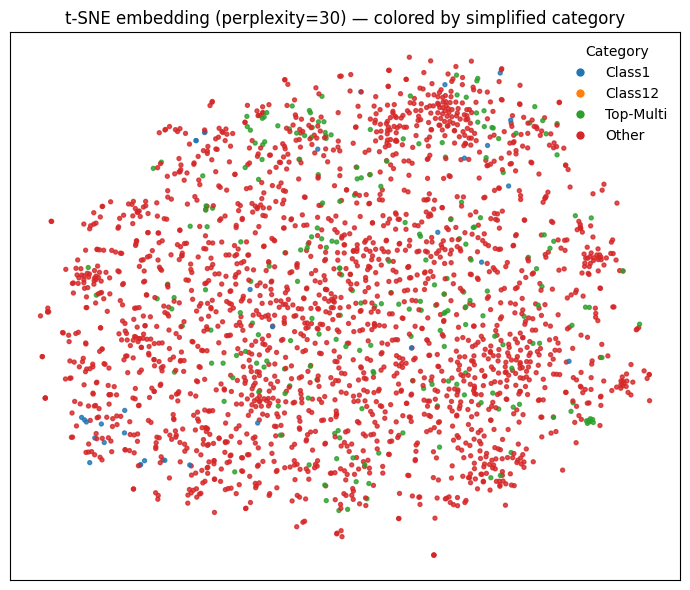

Saved tsne_perp30_coords_labels.csv — contains tsne1, tsne2, label, code.


In [21]:
# === Part B.2: 2D scatter of the chosen t-SNE embedding (perplexity=30) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Preconditions: tsne_results (dict), simplified_label or simplified_code must exist
if 'tsne_results' not in globals():
    raise RuntimeError("Run Part B.1 first to produce tsne_results.")
if 30 not in tsne_results:
    # fallback: pick the first available embedding
    chosen_p = sorted(tsne_results.keys())[0]
    print(f"Warning: perplexity=30 embedding not found. Using perplexity={chosen_p} instead.")
else:
    chosen_p = 30

Z = tsne_results[chosen_p]   # shape (n_samples, 2)

# Build label series (string) and code (int) consistently
if 'simplified_label' in globals():
    labels = simplified_label.reset_index(drop=True).astype(str)
    # preserve the previously chosen category order if present
    try:
        order = categories
    except Exception:
        order = list(pd.Categorical(labels).categories)
elif 'simplified_code' in globals() and 'categories' in globals():
    labels = pd.Series([categories[int(c)] for c in simplified_code], name='simplified_label')
    order = categories
else:
    raise RuntimeError("Need simplified_label (or simplified_code + categories). Run Part A.3.")

# deterministic color mapping
cmap = plt.get_cmap('tab10')
color_map = {cat: cmap(i % 10) for i, cat in enumerate(order)}
point_colors = [color_map.get(l, color_map[order[-1]]) for l in labels]

# Build a dataframe with coordinates and labels for later inspection
tsne_df = pd.DataFrame({
    'tsne1': Z[:,0],
    'tsne2': Z[:,1],
    'label': labels
})
# numeric code too
cat_to_code = {c: i for i, c in enumerate(order)}
tsne_df['code'] = tsne_df['label'].map(cat_to_code).astype(int)

# Plot
plt.figure(figsize=(7,6))
plt.scatter(tsne_df['tsne1'], tsne_df['tsne2'], c=[color_map[l] for l in tsne_df['label']], s=8, alpha=0.8)
plt.title(f"t-SNE embedding (perplexity={chosen_p}) — colored by simplified category")
plt.xticks([]); plt.yticks([])

# Legend (ordered)
handles = [plt.Line2D([0],[0], marker='o', color='w', markerfacecolor=color_map[cat], markersize=7) for cat in order]
plt.legend(handles, order, title='Category', loc='best', frameon=False)

plt.tight_layout()
plt.show()

# Save coordinates + labels so you can inspect later
tsne_df.to_csv("tsne_perp30_coords_labels.csv", index=False)
print("Saved tsne_perp30_coords_labels.csv — contains tsne1, tsne2, label, code.")


### Part B.3 – Label Veracity Inspection

Using the 2-D t-SNE embedding, we visually and quantitatively inspect label
veracity (truthfulness and consistency).

**Goals :**
1. Detect *noisy / ambiguous* labels — points whose nearest neighbors mostly
   belong to a different category.  
2. Detect *outliers* — points that are isolated or far from any cluster center.  
3. Highlight *hard-to-learn* regions — areas where multiple categories overlap
   densely in the embedding.

We perform a simple neighborhood-based analysis on the t-SNE coordinates to flag
suspect samples for each of these categories.  The results provide intuition
about label reliability and dataset quality.


Summary of detected samples:
 Noisy label candidates : 248
 Outliers               : 121
 Hard-to-learn regions  : 207


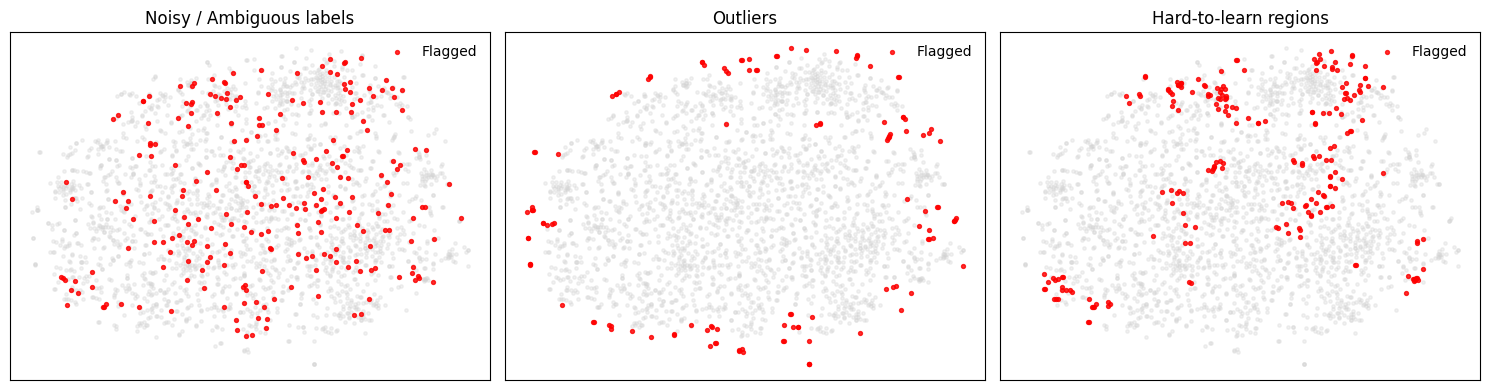

In [22]:
# === Part B.3: Veracity inspection using t-SNE embedding ===
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Preconditions
if 'tsne_df' not in globals():
    raise RuntimeError("Run Part B.2 first to create tsne_df (tsne1, tsne2, label).")

coords = tsne_df[['tsne1','tsne2']].values
labels = tsne_df['label'].values
unique_labels = np.unique(labels)

# --- 1) Nearest-neighbor label agreement ---
k = 10
nbrs = NearestNeighbors(n_neighbors=k+1).fit(coords)
distances, indices = nbrs.kneighbors(coords)
# ignore the first neighbor (itself)
neighbor_labels = labels[indices[:,1:]]
match_fraction = np.array([
    np.mean(neigh == lbl)
    for neigh, lbl in zip(neighbor_labels, labels)
])
tsne_df['neighbor_agreement'] = match_fraction

# samples with low agreement → possible noisy labels
noisy_mask = match_fraction < 0.4   # <40 % neighbors share same label
tsne_df['is_noisy'] = noisy_mask

# --- 2) Outlier detection in 2-D space ---
# use distance to the k-th nearest neighbor as isolation measure
local_radius = distances[:, -1]
threshold = np.percentile(local_radius, 95)  # top 5 % farthest
outlier_mask = local_radius > threshold
tsne_df['is_outlier'] = outlier_mask

# --- 3) Hard-to-learn region heuristic ---
# region entropy of neighbor label distribution
from scipy.stats import entropy
entropy_values = []
for neigh in neighbor_labels:
    counts = np.array([np.sum(neigh == u) for u in unique_labels])
    probs = counts / np.sum(counts)
    entropy_values.append(entropy(probs + 1e-9, base=2))
tsne_df['local_entropy'] = entropy_values
entropy_thresh = np.percentile(entropy_values, 90)
tsne_df['is_hard'] = tsne_df['local_entropy'] > entropy_thresh

print("Summary of detected samples:")
print(f" Noisy label candidates : {tsne_df['is_noisy'].sum()}")
print(f" Outliers               : {tsne_df['is_outlier'].sum()}")
print(f" Hard-to-learn regions  : {tsne_df['is_hard'].sum()}")

# --- 4) Visualize flagged samples ---
fig, axes = plt.subplots(1,3, figsize=(15,4))
titles = ['Noisy / Ambiguous labels','Outliers','Hard-to-learn regions']
masks = [noisy_mask, outlier_mask, tsne_df['is_hard']]

for ax, title, mask in zip(axes, titles, masks):
    ax.scatter(tsne_df['tsne1'], tsne_df['tsne2'],
               c='lightgray', s=6, alpha=0.3)
    ax.scatter(tsne_df.loc[mask,'tsne1'],
               tsne_df.loc[mask,'tsne2'],
               c='red', s=8, alpha=0.8, label='Flagged')
    ax.set_title(title)
    ax.set_xticks([]); ax.set_yticks([])
    ax.legend(frameon=False)

plt.tight_layout()
plt.show()


#### Part B.3 – Hard-to-Learn Regions and Classifier Difficulty

The highlighted *hard-to-learn* regions represent areas in the t-SNE embedding
where multiple label categories overlap or intermix densely.  
Within these zones, the local label entropy is high — neighboring points often
belong to different classes despite being close in the manifold space.

A simple classifier (e.g. Logistic Regression, Linear SVM, or Decision Tree)
would likely **struggle** in these regions because:

1. **Low class separability:**  
   The boundaries between categories are not linearly separable in the
   projected space, leading to overlapping feature distributions.

2. **High local ambiguity:**  
   Neighboring points show inconsistent labels.  
   A classifier relying on smooth decision boundaries cannot assign confident
   predictions when the same neighborhood contains samples of multiple classes.

3. **Noise and label inconsistency:**  
   Some of these mixed regions may correspond to mislabeled or biologically
   ambiguous samples, further confusing the learning process.

4. **Bias–variance trade-off:**  
   Simpler models that enforce global decision boundaries will underfit these
   complex local structures, while highly flexible models (e.g. deep nets)
   might overfit noise instead of capturing true patterns.

Hence, these regions indicate *intrinsic uncertainty* in the dataset — areas
where improving label quality or adding richer features would likely yield a
greater performance gain than merely changing the model architecture.


---

## Part C: Isomap and Manifold Learning:
### C.1 & C.2 – Isomap Implementation, Visualization & Comparison with t-SNE

We now apply the **Isomap** algorithm to the same standardized feature matrix (`X_scaled`) 
to obtain a 2-D manifold embedding.

### Fundamental Difference: t-SNE vs Isomap
- **t-SNE** is primarily a **local structure–preserving** method.  
  It focuses on maintaining relative distances among nearby points by converting 
  pairwise similarities into conditional probabilities.  As a result, it highlights 
  fine-grained cluster patterns but often distorts large-scale geometry 
  (the global distances between clusters are not meaningful).

- **Isomap**, in contrast, is a **global structure–preserving** manifold learner.  
  It first builds a *k-nearest-neighbor graph* on the data and estimates 
  *geodesic distances* (shortest paths along the manifold).  
  Then it performs classical MDS (Multidimensional Scaling) on these geodesic 
  distances to obtain the low-dimensional embedding.  
  Hence, Isomap tries to preserve the overall geometry and relative positioning 
  of distant regions on the manifold.


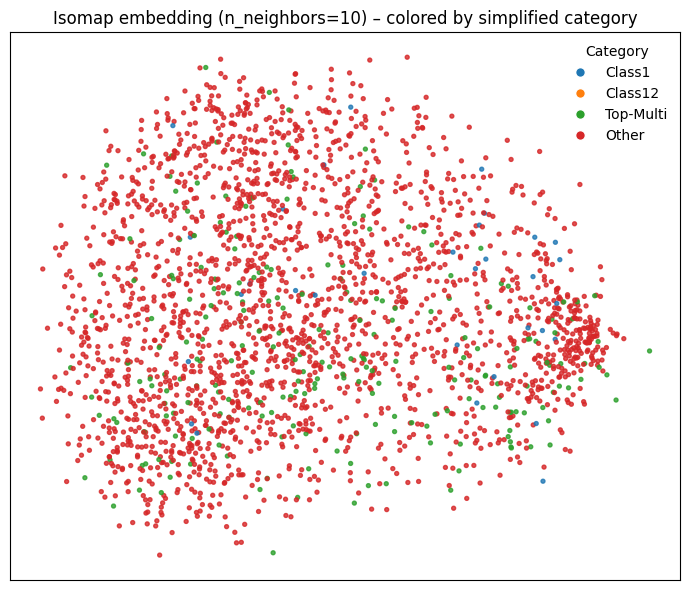

Isomap completed with 10 nearest neighbors; result shape: (2417, 2)


In [23]:
# === Part C – Isomap embedding (2 components) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import Isomap

# Preconditions
if 'X_scaled' not in globals():
    raise RuntimeError("X_scaled not found. Run Part A.4 first.")
if 'simplified_label' not in globals() and 'simplified_code' not in globals():
    raise RuntimeError("simplified labels not found. Run Part A.3 first.")

# Build labels and color mapping (reuse previous colors)
if 'simplified_label' in globals():
    labels = simplified_label.reset_index(drop=True).astype(str)
    try:
        order = categories
    except Exception:
        order = list(pd.Categorical(labels).categories)
elif 'simplified_code' in globals() and 'categories' in globals():
    labels = pd.Series([categories[int(c)] for c in simplified_code], name='simplified_label')
    order = categories

cmap = plt.get_cmap('tab10')
color_map = {cat: cmap(i % 10) for i, cat in enumerate(order)}
point_colors = [color_map.get(l, color_map[order[-1]]) for l in labels]

# --- Run Isomap ---
n_neighbors = 10   # typical small neighborhood size
iso = Isomap(n_neighbors=n_neighbors, n_components=2)
Z_iso = iso.fit_transform(X_scaled)

# --- Build DataFrame for consistency ---
isomap_df = pd.DataFrame({
    'iso1': Z_iso[:,0],
    'iso2': Z_iso[:,1],
    'label': labels
})

# --- Plot ---
plt.figure(figsize=(7,6))
plt.scatter(isomap_df['iso1'], isomap_df['iso2'], c=point_colors, s=8, alpha=0.8)
plt.title(f"Isomap embedding (n_neighbors={n_neighbors}) – colored by simplified category")
plt.xticks([]); plt.yticks([])

handles = [plt.Line2D([0],[0], marker='o', color='w', markerfacecolor=color_map[cat], markersize=7) for cat in order]
plt.legend(handles, order, title='Category', loc='best', frameon=False)

plt.tight_layout()
plt.show()

print(f"Isomap completed with {n_neighbors} nearest neighbors; result shape: {Z_iso.shape}")


### Part C.3 — Comparison and Curvature

#### Comparison of Global Structure (Isomap vs t-SNE)
When comparing the two embeddings, **t-SNE** emphasizes the preservation of *local
neighborhoods* — it clusters points that are similar in the high-dimensional space,
but it can distort how far apart clusters actually are from each other.  
In contrast, **Isomap** preserves *global manifold geometry* by maintaining
approximate geodesic distances between all points.  

As a result, the **Isomap plot provides a clearer view of the overall global
structure** of the gene-expression data: the relative placement of distant regions
is more meaningful, and the embedding better reflects the continuous transitions
across the manifold.  
t-SNE, while excellent at revealing small, well-defined clusters, tends to break
the data into separate “islands” that may not correspond to true global
relationships. Therefore, **Isomap is better at revealing the global structure**
of the dataset.


#### Discussion on Data Manifold and Curvature
The concept of a **data manifold** refers to the low-dimensional surface or space
within the high-dimensional feature space on which most of the meaningful data
points lie.  
If this manifold is **highly curved or complex**, distances measured in the
original space are not well-approximated by simple linear projections — the data
wraps around itself in ways that make global unfolding difficult.

From the Isomap embedding, the manifold appears **non-linear and moderately
curved** — clusters transition smoothly but not linearly, indicating that the
underlying gene-expression relationships are complex.  
Such curvature implies that **simple classifiers** (like linear SVM or logistic
regression) will struggle, because they assume flat, separable boundaries.
These algorithms cannot capture the non-linear transitions that define class
boundaries on the manifold.  
Thus, the complexity of this manifold explains why higher-capacity or
non-linear models (e.g., kernel methods or neural networks) would be needed to
achieve accurate classification.
